In [12]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
experiments = 5
epochs = 200

activations = ['selu', 'sigmoid']
optimizers = ['Adamax', 'sgd']

colors = ['#000000', '#330000', '#660000', '#990000', '#CC0000', '#FF0000',
          '#003300', '#006600', '#009900', '#00CC00', '#00FF00',
          '#000033', '#000066', '#000099', '#0000CC', '#0000FF',
          '#033000', '#066000', '#099000', '#0CC000', '#0FF000',
          '#000330', '#000660', '#000990', '#000CC0', '#000FF0']
colors_new = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', 'y', 'm', 'c', '#CC0066', '#6600CC', '#066000', '#000000']
colors_opt = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', 'y', 'm', 'c', '#CC0066', '#6600CC', '#066000', '#000000']
lines = ['-', '--', ':', '-.']
cols_f = []
for c in colors:
    for l in lines:
        cols_f.append(c+l)
        
columns=['epoch', 'acc', 'loss', 'val_acc', 'val_loss']

configs = [
    {
        'type': 'ReduceLR',
        'type_file': 'lr',
        'rate': 0.2
    },
    {
        'type': 'ReduceLR',
        'type_file': 'lr',
        'rate': 0.35
    },
    {
        'type': 'ReduceLR',
        'type_file': 'lr',
        'rate': 0.5
    },
    {
        'type': 'LR Decay',
        'type_file': 'decay',
        'rate': 0.0001
    },
    {
        'type': 'Fixed LR',
        'type_file': 'fixed',
        'rate': 0.1
    },
    {
        'type': 'Fixed LR',
        'type_file': 'fixed',
        'rate': 0.01
    },
    {
        'type': 'Fixed LR',
        'type_file': 'fixed',
        'rate': 0.002
    },
    {
        'type': 'Fixed LR',
        'type_file': 'fixed',
        'rate': 0.001
    }
]


In [17]:
def data_label(prefix):
    if prefix == 'normd':
        return 'Normalized data'
    elif prefix == 'std_sample_wise':
        return 'Standardized data'

def load_data(path, prefix, configs, experiments, activations, optimizers, units):
    data = []
    i = 1
    for act in activations:
        for opt in optimizers:
            for cfg in configs:

                print(' ' * 100, end='\r')
                print('Loading data for combination %d of %d' % (i, len(activations) * len(optimizers) * len(configs)), end='\r')
                
                initial_lr_text = ''
                
                if cfg['type_file'] != 'fixed':
                    if opt == 'sgd':
                        initial_lr_text = ', initial LR = 0.01'
                    elif opt == 'Adamax':
                        initial_lr_text = ', initial LR = 0.002'
                
                lr_name = '%s (%s)%s' % (str(cfg['type']), str(cfg['rate']), initial_lr_text)
                name = 'Activation: %s, Optimizer: %s, %s, %s' % (act, opt, lr_name, data_label(prefix))
                file_name = '_'.join([prefix, cfg['type_file'], str(cfg['rate']), act, opt])
                    
                data.append({
                    'name': name,
                    'col': colors[i % len(colors)],
                    'line': lines[i % len(lines)],
                    'act': act,
                    'lr_name': lr_name,
                    'opt': opt,
                    'type': cfg['type'] + initial_lr_text,
                    'rate': cfg['rate'],
                    'data_type': prefix,
                    'data' : [pd.read_csv(path + file_name + '_' + str(ex)  + '_' + str(units) + '.csv') for ex in range(experiments)],
                    'max_val_acc':{},

                })

                i+=1
            
    return data

def parse_data(data, epochs, experiments):
    i=1
    for d in range(len(data)):
        
        print(' ' * 100, end='\r')
        print('Parsing data: %d of %d' % (i, len(data)), end='\r')
        
        data[d]['averaged'] = pd.DataFrame(columns=['epoch', 'val_acc'])
        for epoch in range(epochs):
            val_acc = []

            for experiment in range(experiments):
                val_acc.append(data[d]['data'][experiment].iloc[epoch]['val_acc'])

                if epoch == 0:
                    data[d]['max_val_acc'][experiment] = {}
                    data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    data[d]['max_val_acc']['upper_max'] = {}
                    data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc']['upper_max']['epoch'] = epoch
                else:
                    if data[d]['max_val_acc'][experiment]['val_acc'] < data[d]['data'][experiment].iloc[epoch]['val_acc']:
                        data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    if data[d]['data'][experiment].iloc[epoch]['val_acc'] > data[d]['max_val_acc']['upper_max']['val_acc']:
                        data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc']['upper_max']['epoch'] = epoch


            av_val_acc = sum(val_acc)/len(val_acc)

            if epoch == 0:
                data[d]['max_val_acc']['avg'] = {}
                data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                data[d]['max_val_acc']['avg']['epoch'] = epoch
            else:
                if(av_val_acc >= data[d]['max_val_acc']['avg']['val_acc']):
                    data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                    data[d]['max_val_acc']['avg']['epoch'] = epoch

            data[d]['averaged'] = data[d]['averaged'].append({
                'epoch': epoch,
                'val_acc': av_val_acc
            }, ignore_index=True)
            
        data[d]['max_val_acc']['last_max'] = max([data[d]['data'][experiment]['val_acc'].tolist()[-1] for experiment in range(experiments)])
        
        i+=1
    return data

In [18]:
data_normd = load_data('./training_logs/', 'normd', configs, experiments, activations, optimizers, 64)
data_normd = parse_data(data_normd, epochs, experiments)

In [19]:
check_normd = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act', 'data'])
i=0
for d in range(len(data_normd)):
    for experiment in range(experiments):
        check_normd.loc[i] = [data_normd[d]['name'], 
                          experiment,
                          data_normd[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_normd[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_normd[d]['opt'], 
                          data_normd[d]['act'],
                          data_normd[d]['data_type']]
        i+=1

check_normd = check_normd.sort_values(by=['val_acc'])
check_normd

,config,exp,acc,loss,val_acc,val_loss,opt,act,data
159,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",4,0.815000,0.597134,0.8683,0.458621,sgd,sigmoid,normd
158,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",3,0.813450,0.609907,0.8710,0.469770,sgd,sigmoid,normd
157,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",2,0.817483,0.597729,0.8746,0.455686,sgd,sigmoid,normd
155,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",0,0.823283,0.586577,0.8765,0.444805,sgd,sigmoid,normd
156,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",1,0.823067,0.572910,0.8811,0.434702,sgd,sigmoid,normd
137,"Activation: sigmoid, Optimizer: sgd, LR Decay ...",2,0.856167,0.478681,0.8964,0.355341,sgd,sigmoid,normd
136,"Activation: sigmoid, Optimizer: sgd, LR Decay ...",1,0.856067,0.478745,0.8967,0.357049,sgd,sigmoid,normd
138,"Activation: sigmoid, Optimizer: sgd, LR Decay ...",3,0.855000,0.484139,0.8978,0.360478,sgd,sigmoid,normd
135,"Activation: sigmoid, Optimizer: sgd, LR Decay ...",0,0.860183,0.470351,0.9000,0.350066,sgd,sigmoid,normd
139,"Activation: sigmoid, Optimizer: sgd, LR Decay ...",4,0.861917,0.467264,0.9031,0.344375,sgd,sigmoid,normd


In [20]:
data_std = load_data('./training_logs/', 'std', configs, experiments, activations, optimizers, 64)
data_std = parse_data(data_std, epochs, experiments)

In [21]:
check_std = pd.DataFrame(columns=['config', 'exp', 'acc', 'loss', 'val_acc', 'val_loss', 'opt', 'act', 'data'])
i=0
for d in range(len(data_std)):
    for experiment in range(experiments):
        check_std.loc[i] = [data_std[d]['name'], 
                          experiment,
                          data_std[d]['data'][experiment]['acc'].tolist()[-1], 
                          data_std[d]['data'][experiment]['loss'].tolist()[-1], 
                          data_std[d]['data'][experiment]['val_acc'].tolist()[-1], 
                          data_std[d]['data'][experiment]['val_loss'].tolist()[-1], 
                          data_std[d]['opt'], 
                          data_std[d]['act'],
                          data_std[d]['data_type']]
        i+=1
check_std = check_std.sort_values(by=['val_acc'])
check_std

,config,exp,acc,loss,val_acc,val_loss,opt,act,data
23,"Activation: selu, Optimizer: Adamax, Fixed LR ...",3,0.098717,14.526971,0.0980,14.538522,Adamax,selu,std
22,"Activation: selu, Optimizer: Adamax, Fixed LR ...",2,0.549133,7.265810,0.5662,6.991069,Adamax,selu,std
24,"Activation: selu, Optimizer: Adamax, Fixed LR ...",4,0.604083,6.379313,0.6194,6.132038,Adamax,selu,std
21,"Activation: selu, Optimizer: Adamax, Fixed LR ...",1,0.788750,3.404425,0.8175,2.940675,Adamax,selu,std
20,"Activation: selu, Optimizer: Adamax, Fixed LR ...",0,0.811167,3.042731,0.8379,2.610403,Adamax,selu,std
159,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",4,0.888850,0.385364,0.9168,0.286555,sgd,sigmoid,std
156,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",1,0.890033,0.387800,0.9179,0.287867,sgd,sigmoid,std
157,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",2,0.889800,0.382530,0.9184,0.284913,sgd,sigmoid,std
158,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",3,0.892433,0.374187,0.9200,0.278740,sgd,sigmoid,std
155,"Activation: sigmoid, Optimizer: sgd, Fixed LR ...",0,0.892767,0.376081,0.9221,0.278014,sgd,sigmoid,std


In [22]:
results = pd.DataFrame(columns=[#'Configuration', 
                                'Activation',                            
                                'Optimizer',
                                'Type',
                                'Rate',
                                'Data type',
                                'Averaged on Last Epoch', 
                                'Averaged Max Achieved',
                                'Overall Max on Last Epoch',
                                'Overall Max Achieved',
                                'Averaged Max Epoch',
                               ])
j=0
for d in [data_normd, data_std]:
    for i in range(len(d)):
        results.loc[j] = [
            d[i]['act'],
            d[i]['opt'],
            d[i]['type'],
            d[i]['rate'],
            d[i]['data_type'],
            d[i]['averaged']['val_acc'].tolist()[-1] * 100, 
            d[i]['max_val_acc']['avg']['val_acc'] * 100,
            d[i]['max_val_acc']['last_max'] * 100,
            d[i]['max_val_acc']['upper_max']['val_acc'] * 100,
            d[i]['max_val_acc']['avg']['epoch'],

        ]
        j+=1

results_sorted = results.sort_values(by=['Averaged on Last Epoch'], ascending = False)
results_sorted.to_csv('./results.csv')
results_sorted

,Activation,Optimizer,Type,Rate,Data type,Averaged on Last Epoch,Averaged Max Achieved,Overall Max on Last Epoch,Overall Max Achieved,Averaged Max Epoch
34,selu,Adamax,"ReduceLR, initial LR = 0.002",0.5000,std,98.168,98.192,98.25,98.33,178
33,selu,Adamax,"ReduceLR, initial LR = 0.002",0.3500,std,98.132,98.148,98.21,98.26,69
32,selu,Adamax,"ReduceLR, initial LR = 0.002",0.2000,std,98.124,98.130,98.16,98.22,94
39,selu,Adamax,Fixed LR,0.0010,std,98.110,98.138,98.22,98.24,191
35,selu,Adamax,"LR Decay, initial LR = 0.002",0.0001,std,98.078,98.092,98.20,98.27,191
44,selu,sgd,Fixed LR,0.1000,std,98.032,98.086,98.20,98.28,130
6,selu,Adamax,Fixed LR,0.0020,normd,98.032,98.040,98.13,98.18,191
38,selu,Adamax,Fixed LR,0.0020,std,98.024,98.128,98.22,98.40,151
45,selu,sgd,Fixed LR,0.0100,std,98.018,98.040,98.11,98.15,198
5,selu,Adamax,Fixed LR,0.0100,normd,97.986,98.094,98.12,98.22,92


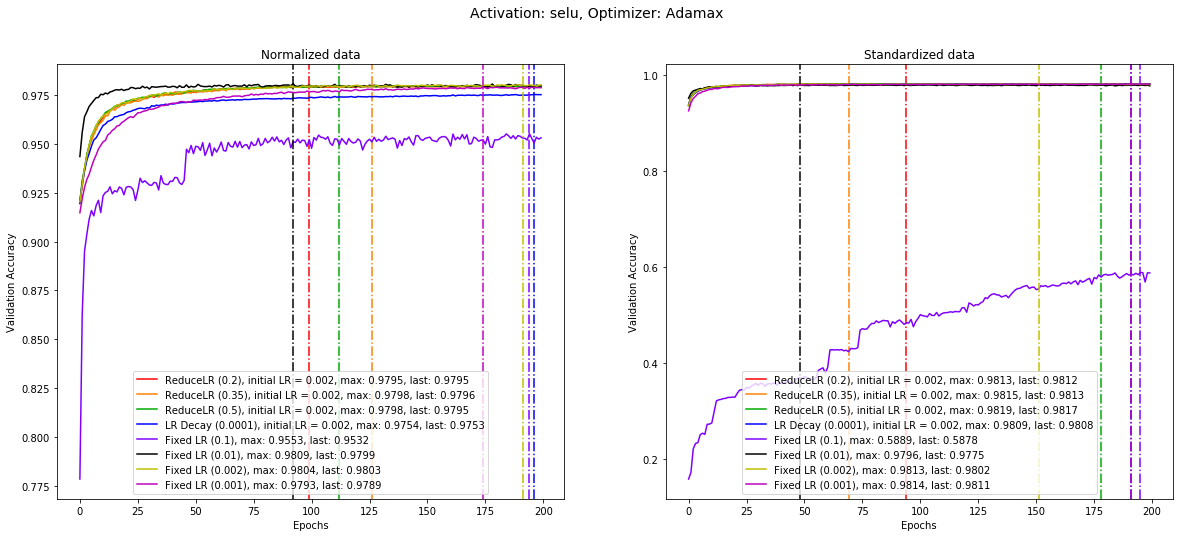

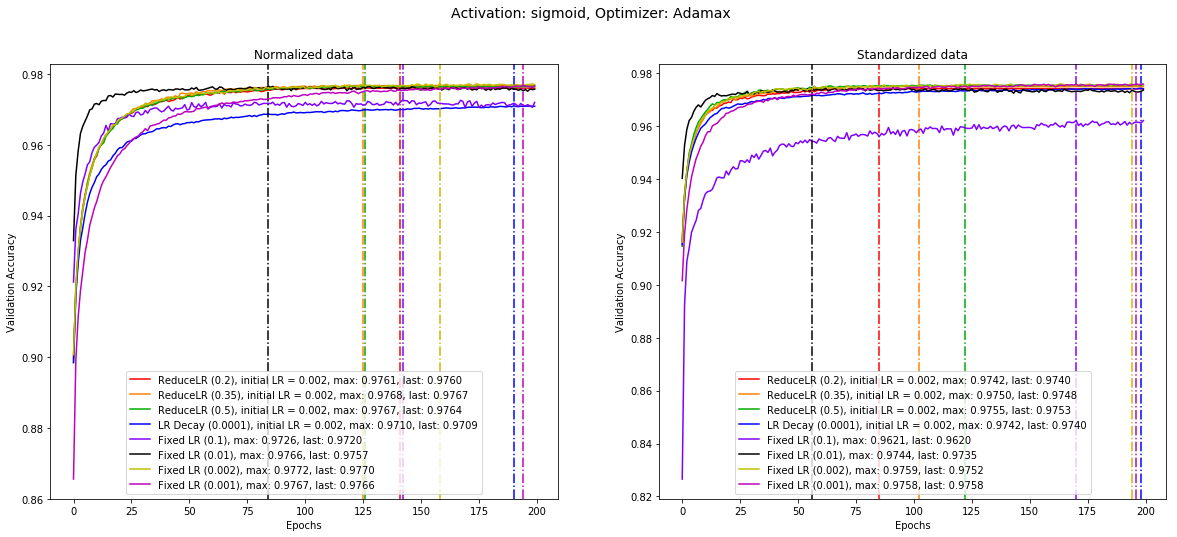

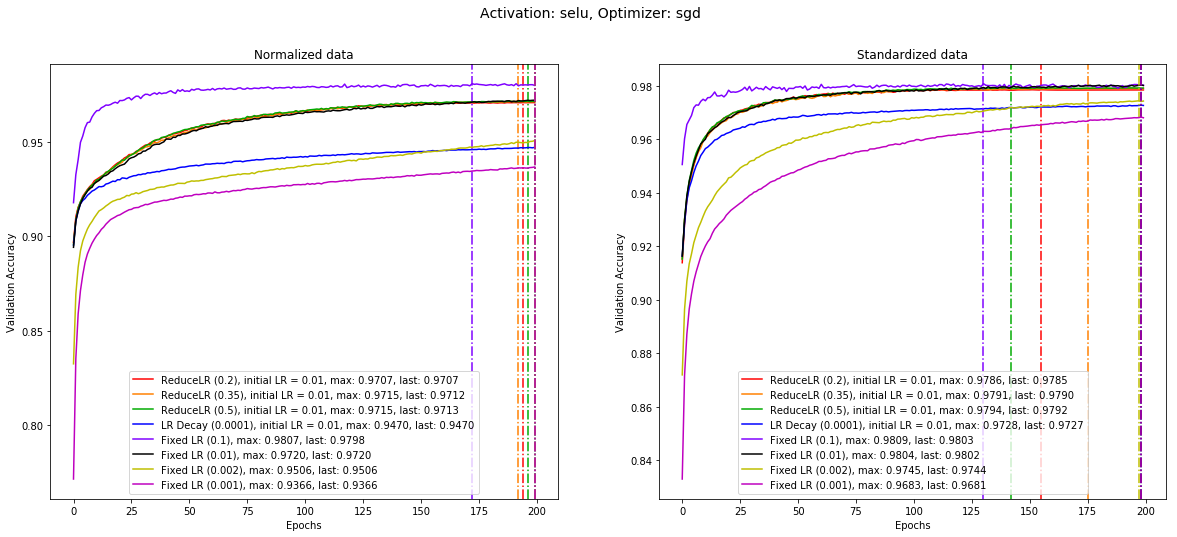

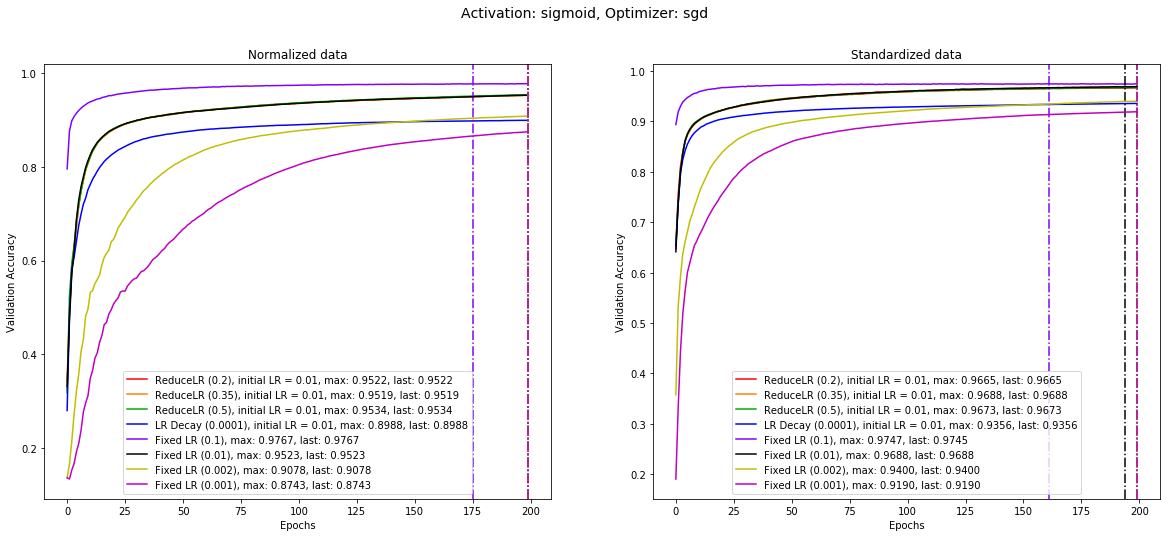

In [23]:
for opt in optimizers:
    for act in activations:
                    
        plt.figure(figsize=(20,8))
        plt.suptitle('Activation: %s, Optimizer: %s' % (act, opt), fontsize=14)
        plt.subplot(1,2,1)
        plt.title('Normalized data')
        clr = 0

        for d in range(len(data_normd)):
            if act == data_normd[d]['act'] and opt == data_normd[d]['opt']:

                plt.plot(range(epochs),
                             data_normd[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_normd[d]['lr_name'] + ', max: %0.4f, last: %0.4f' % (data_normd[d]['max_val_acc']['avg']['val_acc'], data_normd[d]['averaged']['val_acc'].tolist()[-1]))
                
                plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'],
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1

        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        
        clr = 0
        plt.subplot(1,2,2)
        plt.title('Standardized data')

        for d in range(len(data_std)):
            if act == data_std[d]['act'] and opt == data_std[d]['opt']:

                plt.plot(range(epochs),
                             data_std[d]['averaged']['val_acc'].tolist(),
                             colors_new[clr],
                             linestyle='-',
                             label=data_std[d]['lr_name'] + ', max: %0.4f, last: %0.4f' % (data_std[d]['max_val_acc']['avg']['val_acc'], data_std[d]['averaged']['val_acc'].tolist()[-1])) 
                
                plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'], 
                            color = colors_new[clr],                   
                            linestyle='-.')
                
                clr+=1
                
        plt.legend(loc='lower center',ncol=1)
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')

        plt.show()